In [2]:
notebook_path = "Projects/QuantumFlow/notebooks"
try:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)
except:
    pass

# Initialization

This code is not compatible with eager execution.
Please use Tensorflow 1.13.1

In [2]:
!pip install -q tensorflow-gpu==1.13.1

/bin/sh: 1: pip: not found


# Generate Datasets

### Generate M random potentials on [0, L] as sum of n gaussian kernels on G discretization points


there are 3 uniformly distributed random parameters a, b, c
the potential is calculated by:

$$
V(x) = -\sum_{n=1}^{3} a_n \exp \left(-\frac{(x - b_n)^2}{2c_n^2} \right)
$$

### Then solve the schroedinger equation in atomic units for 4 spinless non-interacting fermions.

The shooting numerov algorithm calculates a forward pass and a backward pass solution.

The final solution is then found by aligning the two passes and finding a good split point to concatenate them.

All integrals are approximated by the trapezoidal method.
The numerical differentiation for the laplacian uses the standard approximation.

### Usage:

Setting the dataset variable to different values will allow generating all the variations of the datasets:
standard, recreate, recreate/fine_0.125, ..., recreate/fine_10


In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

import sys
sys.path.append('../')

import ipywidgets as widgets
from IPython.display import display

from quantumflow.generate_potentials import generate_potentials
from quantumflow.calculus_utils import integrate, integrate_simpson, laplace
from quantumflow.numerov_solver import *
from quantumflow.colab_train_utils import test_colab_devices, unpack_dataset
test_colab_devices()

(False, False)

In [8]:
def dataset_parameters(dataset_name):  
    seed = 0
    
    if "recreate" in dataset_name:
        N = 4 # number of electrons
        
        M = dataset_size = 2000 # train dataset size
        M_val = M # validation dataset size
        M_test = M # test dataset size
        
        G = points = 500 # discretization points
        length = 1.0 # [Bohr]

        n_gauss = 3
        a_minmax = (1.0, 10.0) # [hartree] 
        b_minmax = (0.4, 0.6) # nomalized x
        c_minmax = (0.03, 0.1) # normalized x

        # recreate/fine_n
        if "fine" in dataset:
            factor = float(dataset.split('_')[-1])
            G = points = int((500-1)*factor+1)
            M_val = None
            M_test = None
        
        if "seed" in dataset:
            seed = int(dataset.split('_')[-1])
            M = 100
            M_val = None
            M_test = None

    elif "standard" in dataset_name:
        N = 4 # number of electrons
        
        M = dataset_size = 5000 # train dataset size
        M_val = M # validation dataset size
        M_test = M # test dataset size
        
        G = points = 1001 # discretization points
        length = 20.0 # [Bohr]

        n_gauss = 5
        a_minmax = (0.0/n_gauss, 50.0/n_gauss) # [hartree] 
        b_minmax = (.3, 0.7) # nomalized x
        c_minmax = (.02, 0.06) # normalized x

    else:
        raise ValueError("dataset parameters for name '{}' not defined.".format(dataset_name))
        
    return M, M_val, M_test, G, N, length, seed, n_gauss, a_minmax, b_minmax, c_minmax

### Core part of this file:
change the datasets variable for creating different datasets

In [18]:
datadir = "../data"
datasets = []

datasets += ["recreate", "standard"]
datasets += ["recreate/seed_" + str(seed) for seed in range(1, 10)]
datasets += ["recreate/fine_" + str(factor) for factor in [0.125, 0.25, 0.5, 1, 2, 5, 8, 10]]

progress = widgets.IntProgress(value=0, max=0, description='init...', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

for dataset in datasets:
    try:
        M, M_val, M_test, G, N, length, seed, n_gauss, a_minmax, b_minmax, c_minmax = dataset_parameters(dataset)
    except ValueError as e:
        print(e)
        continue
    
    directory = os.path.join(datadir, dataset)
    if not os.path.exists(os.path.join(datadir, dataset)):
            os.makedirs(os.path.join(datadir, dataset))

    for dataset_size, extension in zip([M, M_val, M_test], ["_training", "_validation", "_testing"]):
        if dataset_size is None:
            continue

        np_potentials, np_x = generate_potentials(dataset_size=dataset_size, points=G, n_gauss=n_gauss, length=length,
                                                  a_minmax=a_minmax, b_minmax=b_minmax, c_minmax=c_minmax, 
                                                  return_x=True, seed=seed)

        h = (max(np_x) - min(np_x))/(G-1)

        np_E, np_solutions = NumerovSolver(G, h).solve_schroedinger(np_potentials, N, progress=progress)
        
        filename = 'dataset' + extension + '.pkl'
        with open(os.path.join(directory, filename), 'wb') as f:
            pickle.dump({'x': np_x, 'potential': np_potentials, 'wavefunctions': np_solutions, 'energies': np_E}, f)

        print("dataset", filename, "saved to", directory)

IntProgress(value=0, bar_style='info', description='init...', layout=Layout(width='92%'), max=0)

dataset dataset_training.pkl saved to ../data/recreate/fine_0.125
dataset dataset_training.pkl saved to ../data/recreate/fine_0.25
dataset dataset_training.pkl saved to ../data/recreate/fine_0.5
dataset dataset_training.pkl saved to ../data/recreate/fine_1
dataset dataset_training.pkl saved to ../data/recreate/fine_2
dataset dataset_training.pkl saved to ../data/recreate/fine_5
dataset dataset_training.pkl saved to ../data/recreate/fine_8
dataset dataset_training.pkl saved to ../data/recreate/fine_10


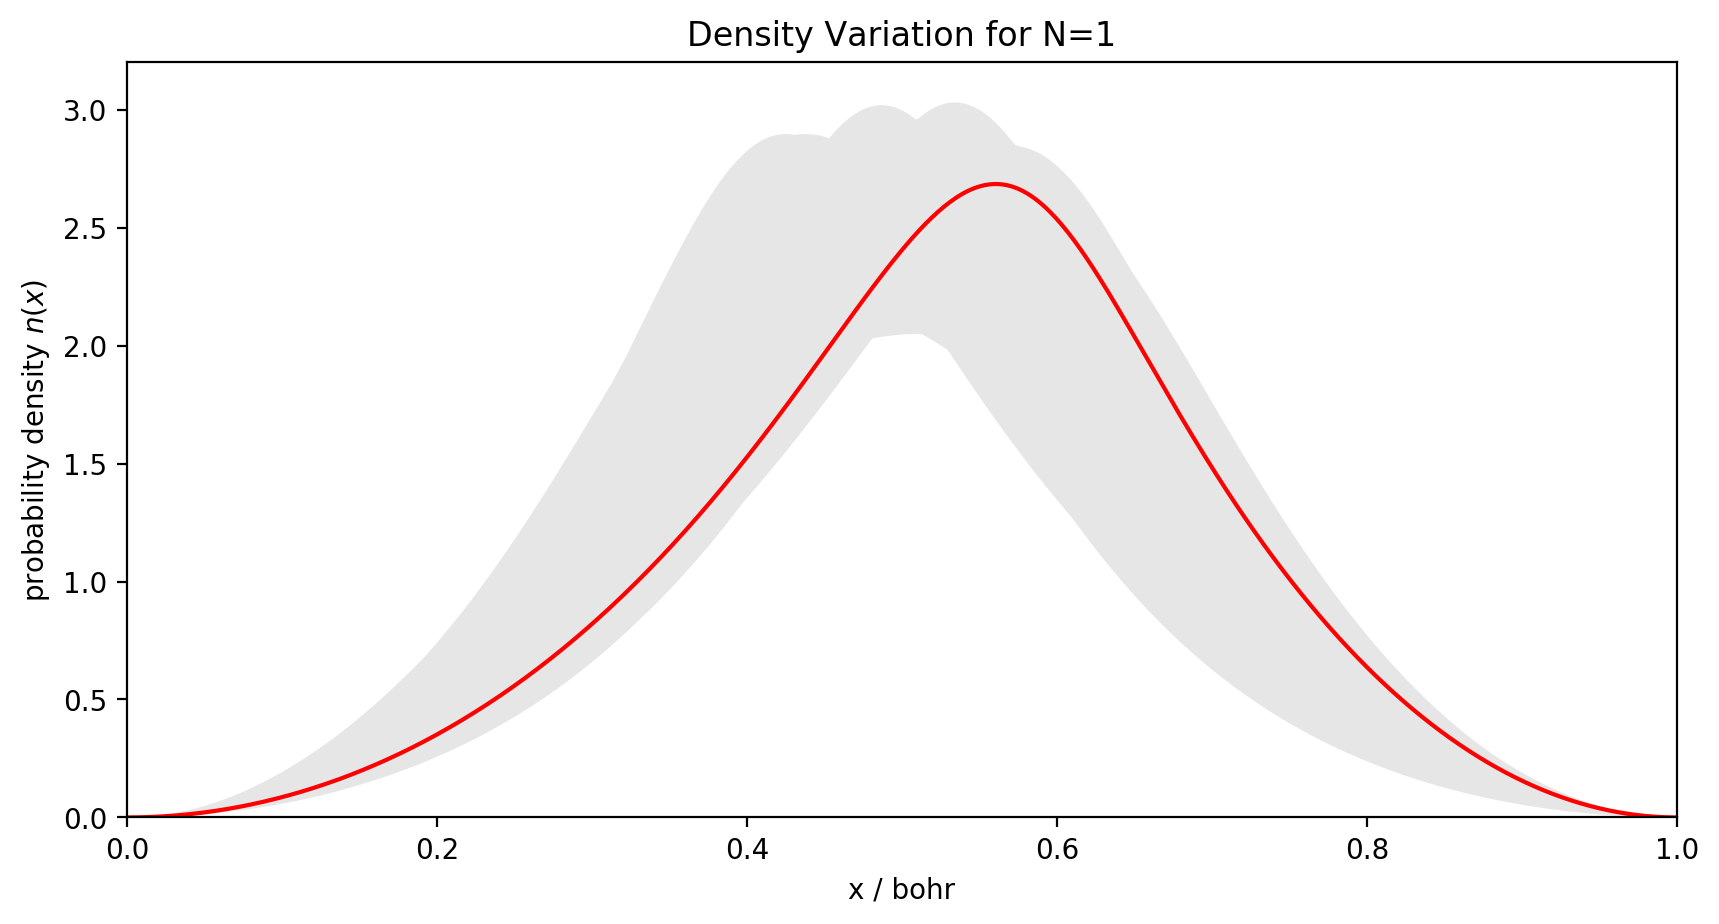

In [19]:
datadir = "../data"
dataset = "recreate"

N = 1
    
with open(os.path.join(datadir, dataset, 'dataset_training.pkl'), 'rb') as f:
    np_x, np_potentials, np_wavefunctions, np_energies, np_densities, np_kenergies, M, G, h = unpack_dataset(N, pickle.load(f))
    
with open(os.path.join(datadir, 'recreate_paper', 'dataset_sample.pkl'), 'rb') as f:
    _, _, _, _, np_sample_density, _, _, _, _ = unpack_dataset(N, pickle.load(f))
    

plt.figure(figsize=(10, 5), dpi=200)
plt.fill_between(np_x, np.min(np_wavefunctions[:, :, 0]**2, axis=0), 
                       np.max(np_wavefunctions[:, :, 0]**2, axis=0), facecolor='0.9')

plt.plot(np_x, np.transpose(np_sample_density[0]), 'r')
#plt.plot(np_x, np.transpose(np_sample_density[0]), '--k')

plt.title('Density Variation for N='+str(N))
plt.xlim([0, 1])
plt.ylim([0, 3.2])
plt.xlabel('x / bohr')
plt.ylabel('probability density $n(x)$')
#plt.grid()
plt.show()

# Algorithm explanation

In [6]:
dataset = "recreate"
M, _, _, G, N, length, seed, n_gauss, a_minmax, b_minmax, c_minmax = dataset_parameters(dataset)

print("Dataset:", dataset)
print("")
print("dataset size M:", M)
print("discretiation points G:", G)
print("1D box length:", length, 'bohr')
print("")
print("potential function parameters:")
print("seed:", seed)
print("number of gaussian functions:", n_gauss)
print("a uniform: ", list(a_minmax))
print("b uniform: ", list(b_minmax))
print("c uniform: ", list(c_minmax))

Dataset: recreate

dataset size M: 2000
discretiation points G: 500
1D box length: 1.0 bohr

potential function parameters:
seed: 0
number of gaussian functions: 3
a uniform:  [1.0, 10.0]
b uniform:  [0.4, 0.6]
c uniform:  [0.03, 0.1]


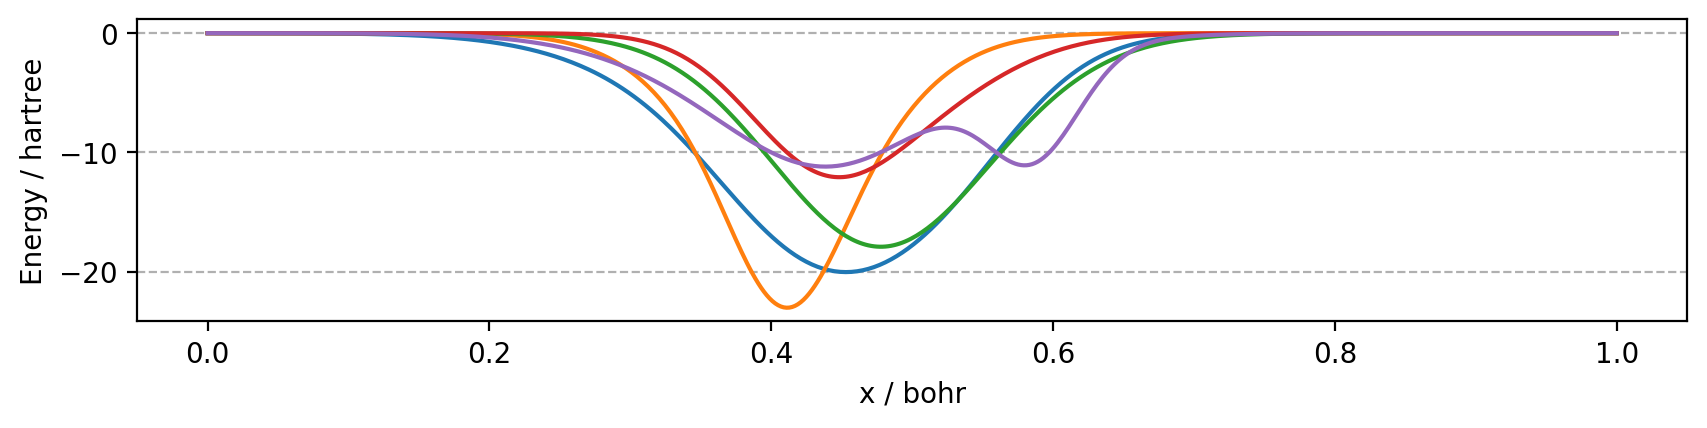

In [9]:
np_potentials, np_x = generate_potentials(dataset_size=M, points=G, n_gauss=n_gauss, length=length,
                                          a_minmax=a_minmax, b_minmax=b_minmax, c_minmax=c_minmax, 
                                          return_x=True, seed=seed)
h = (max(np_x) - min(np_x))/(G-1) # discretization width [bohr]

preview = 5

#plt.figure(figsize=(10, 2), dpi=200)
plt.figure(figsize=(20, 4))
plt.plot(np_x, np.transpose(np_potentials)[:, :preview]) # only plot first potentials
plt.title("Randomly Generated Potentials")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [6]:
tf.reset_default_graph()
solver = NumerovSolver(G, h)

W0820 18:49:14.161119 139905234585472 deprecation_wrapper.py:119] From ../quantumflow/numerov_solver.py:54: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 18:49:14.200353 139905234585472 deprecation.py:323] From ../quantumflow/numerov_solver.py:38: static_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [7]:
progress = widgets.IntProgress(value=0, max=np_potentials.shape[0], description='Searching:', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

split_energies, steps = solver.find_split_energies(np_potentials, N, progress=progress)
print("found all split energies in", steps, "steps")
print("shape:", split_energies.shape)

IntProgress(value=0, bar_style='info', description='Searching:', layout=Layout(width='92%'), max=2000)

found all split energies in 19 steps
shape: (2000, 5)


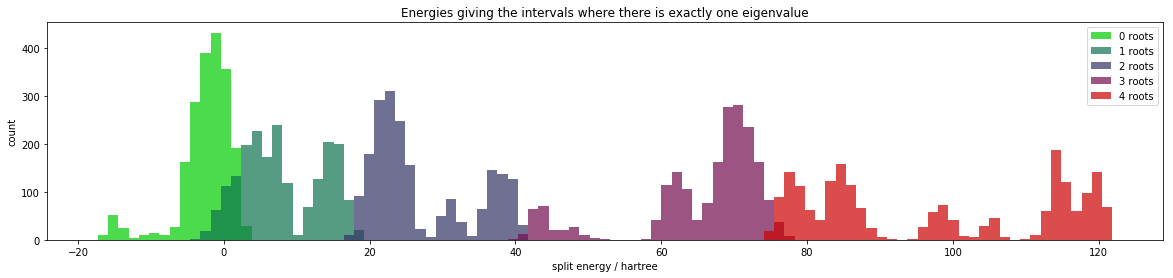

In [8]:
plt.figure(figsize=(20, 4))
bins = np.linspace(min(split_energies.flatten()), max(split_energies.flatten()), 100)

for i in range(split_energies.shape[1]):
    color = i/(split_energies.shape[1] - 1)
    plt.hist(split_energies[:, i], bins, alpha=0.7, color=[0.8*color**2, 0.8*(1-color)**2, 1.6*color*(1-color)], label= str(i) + " roots")

plt.xlabel('split energy / hartree')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title("Energies giving the intervals where there is exactly one eigenvalue")
plt.show()

IntProgress(value=0, bar_style='info', description='Searching:', layout=Layout(width='92%'), max=2000)

steps to convergence:  37


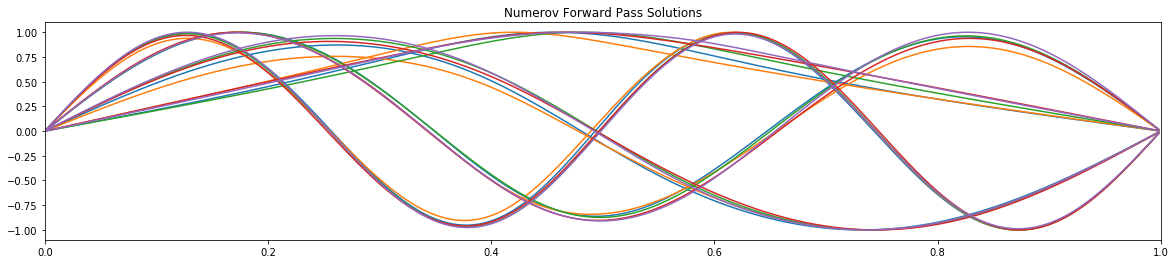

In [9]:
progress = widgets.IntProgress(value=0, max=np_potentials.shape[0], description='Searching:', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

target_roots = np.repeat(np.expand_dims(np.arange(N), axis=0), M, axis=0)
np_solutions_forward, np_E_forward, steps = solver.solve_numerov(np_potentials, target_roots, split_energies, progress=progress)
np_solutions_forward /= np.expand_dims(np.nanmax(np.abs(np_solutions_forward), axis=1), axis=1)
print("steps to convergence: ", steps)

assert not np.any(np.all(np.isnan(np_solutions_forward), axis=1))

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_forward[:preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
plt.xlim(np_x[[0, -1]])
plt.title('Numerov Forward Pass Solutions')
plt.show()


IntProgress(value=0, bar_style='info', description='Searching:', layout=Layout(width='92%'), max=2000)

steps to convergence:  37


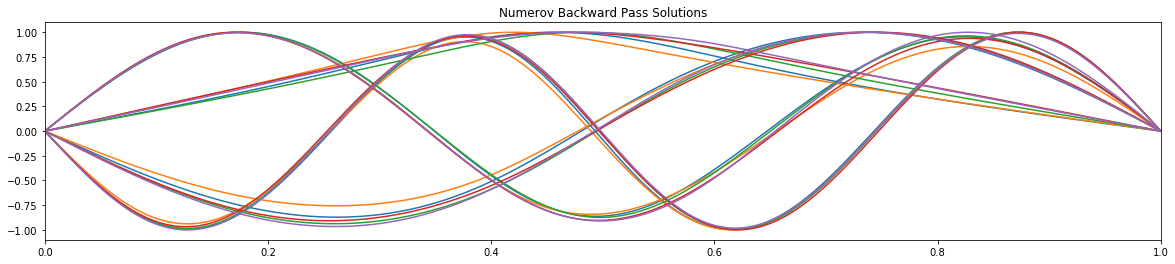

In [10]:
progress = widgets.IntProgress(value=0, max=np_potentials.shape[0], description='Searching:', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

np_solutions_backward, np_E_backward, steps = solver.solve_numerov(np.flip(np_potentials, axis=1), target_roots, split_energies, progress=progress)
np_solutions_backward = np.flip(np_solutions_backward, axis=1)
np_solutions_backward /= np.expand_dims(np.nanmax(np.abs(np_solutions_backward), axis=1), axis=1)
print("steps to convergence: ", steps)

assert not np.any(np.all(np.isnan(np_solutions_backward), axis=1))

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_backward[:preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
    plt.xlim(np_x[[0, -1]])
plt.title('Numerov Backward Pass Solutions')
plt.show()


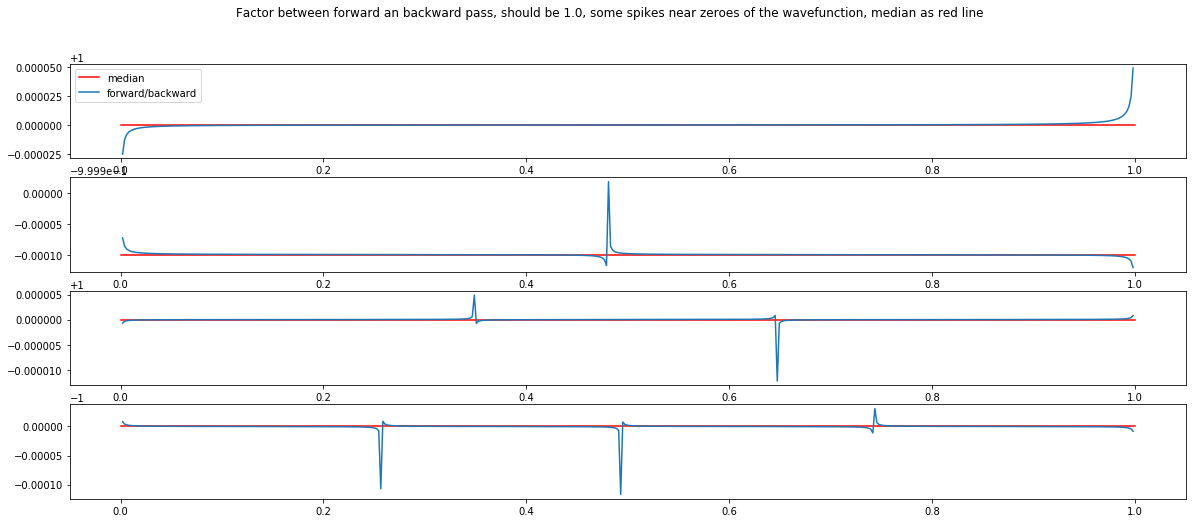

In [11]:
np_factor = np_solutions_forward/np_solutions_backward
np_median = np.nanmedian(np_factor, axis=1)

assert not np.any(np.all(np.isnan(np_factor), axis=1))

merge_preview = 1
merge_preview_n_max = 4

fig, axs = plt.subplots(N, 1, figsize=(20, 8))
for i, np_plot in enumerate(np_factor[:merge_preview]):
    for n, np_plot_single in enumerate(np_plot.transpose()):
        axs[n].plot(np_x, np.ones(np_x.shape)*np_median[i, n], 'r', label="median")
        axs[n].plot(np_x, np_plot_single, 'C' + str(i%10), label="forward/backward")
        if n == 0: axs[n].legend(loc='best')
fig.suptitle('Factor between forward an backward pass, should be 1.0, some spikes near zeroes of the wavefunction, median as red line')
plt.show()


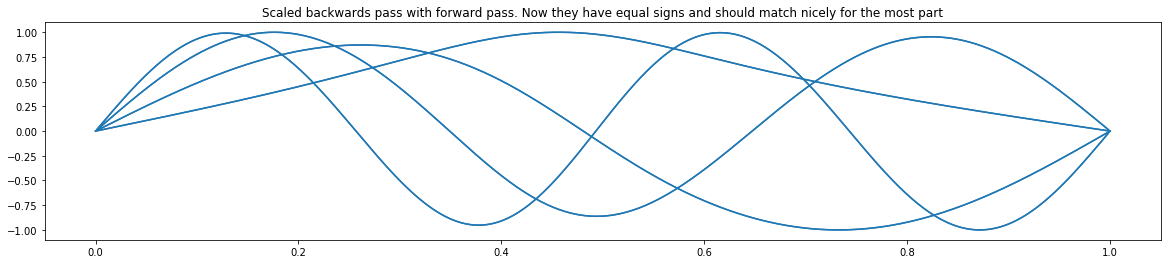

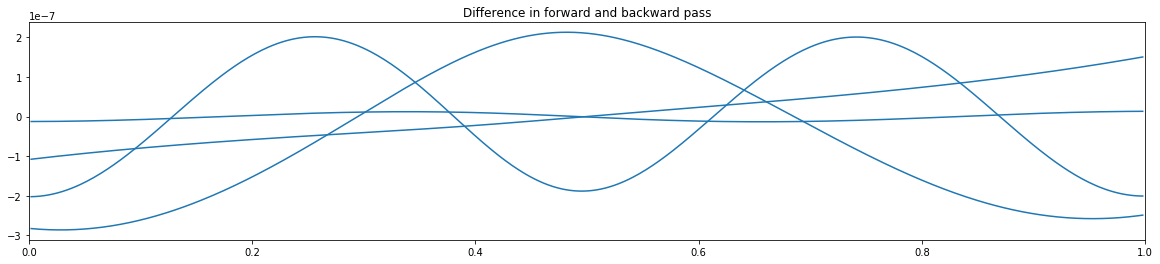

maximal absolute errors:
[[1.50412143e-07 2.86306520e-07 1.32523554e-08 2.02413617e-07]]
dataset maximal absolute error: 6.18264724732559e-07


In [12]:
np_solutions_backward_scaled = np_solutions_backward*np.expand_dims(np_median, axis=1)

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_backward_scaled[:merge_preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
for i, np_plot in enumerate(np_solutions_forward[:merge_preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
plt.title('Scaled backwards pass with forward pass. Now they have equal signs and should match nicely for the most part')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_forward[:merge_preview] - np_solutions_backward_scaled[:merge_preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
plt.xlim(np_x[[0, -1]])
plt.title('Difference in forward and backward pass')
plt.show()

join_error = np.nanmax(np.abs(np_solutions_backward_scaled - np_solutions_forward), axis=1)
print("maximal absolute errors:")
print(join_error[:merge_preview])
print("dataset maximal absolute error:", np.max(join_error))

In [0]:
join_index = np.nanargmin(np.abs(np_solutions_backward_scaled - np_solutions_forward), axis=1)
join_mask = np.expand_dims(np.expand_dims(np.arange(np_solutions_backward_scaled.shape[1]), axis=0), axis=2) >= np.expand_dims(join_index, axis=1)

np_solutions = np_solutions_forward.copy()
np_solutions[join_mask] = np_solutions_backward_scaled[join_mask]

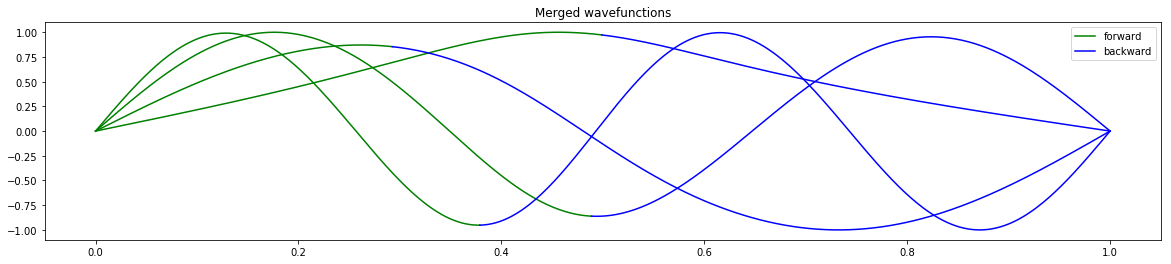

In [14]:
plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions[:merge_preview]):
    for n, np_plot_single in enumerate(np_plot.transpose()):
        plt.plot(np_x[:join_index[i, n]], np_solutions_forward[i, :join_index[i, n], n], 'g')
        plt.plot(np_x[join_index[i, n]-1:], np_solutions_backward_scaled[i, join_index[i, n]-1:, n], 'b')
plt.legend(['forward', 'backward'])
plt.title('Merged wavefunctions')
plt.show()

In [15]:
# normalization
np_norm = np_solutions**2
np_norm = integrate_simpson(np_norm, h, axis=1)
np_solutions *= 1/np.sqrt(np.expand_dims(np_norm, axis=1))

assert not np.any(np.all(np.isnan(np_solutions), axis=1))

print('max energy error:', np.max(np_E_forward - np_E_backward))
np_E = 0.5*(np_E_forward + np_E_backward)

max energy error: 0.0


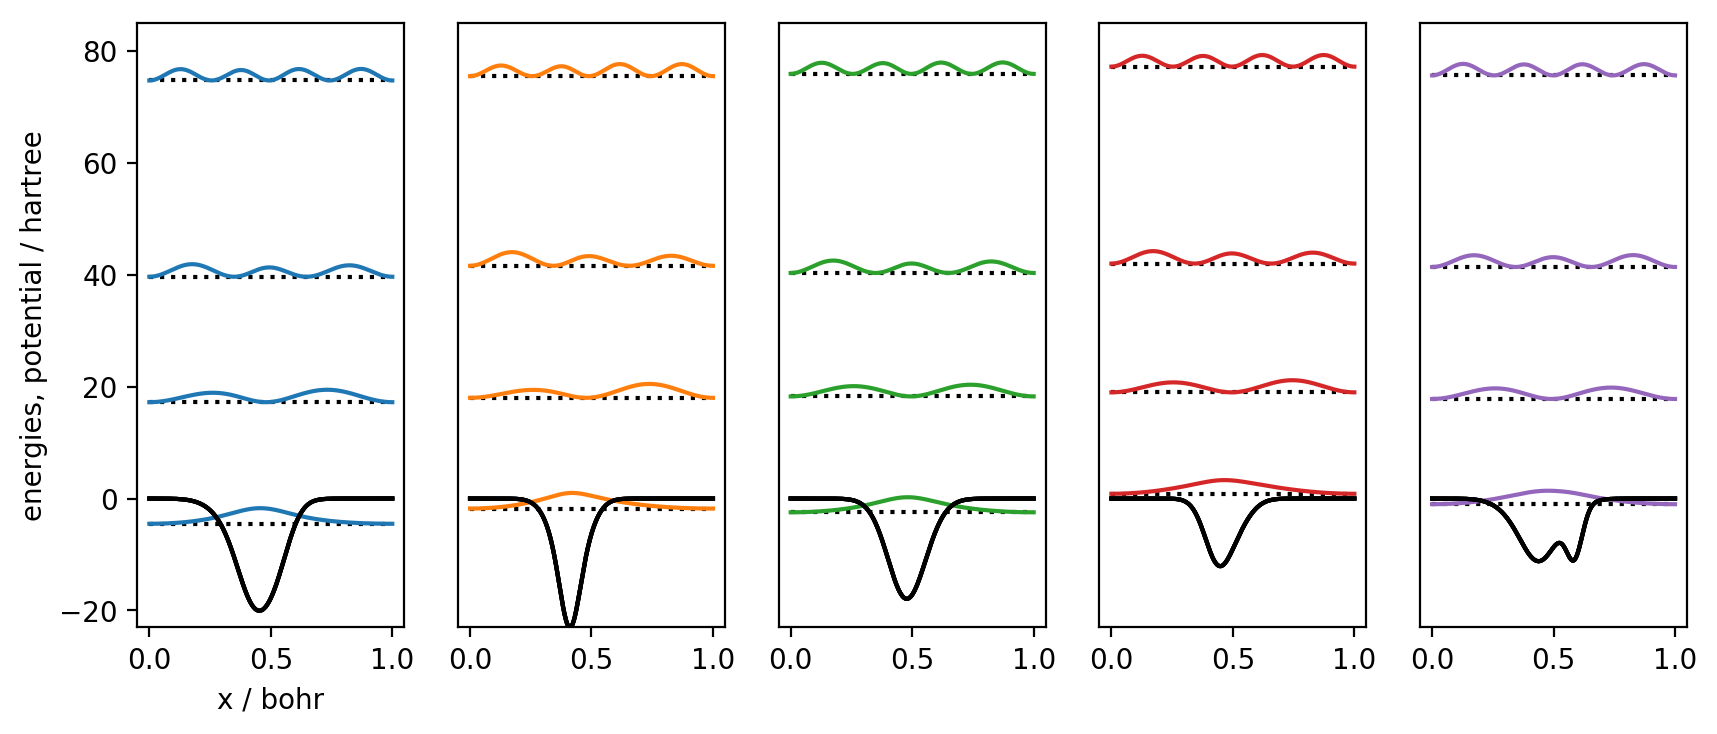


eigenvalue energies:
 [[-4.5098505 17.21072   39.621773  74.6875   ]
 [-1.7928832 17.99112   41.577255  75.45615  ]
 [-2.4623857 18.242489  40.29576   75.86047  ]
 ...
 [-5.1639366 16.200123  39.650208  73.54074  ]
 [-3.908361  17.667313  39.867996  74.829315 ]
 [-3.9168334 17.389843  40.089317  74.77812  ]]


In [16]:
fig, axs = plt.subplots(1, preview, figsize=(10, 4), dpi=200)
#fig, axs = plt.subplots(1, preview, figsize=(20, 8))
for i, np_plot in enumerate(np_solutions[:preview]**2 + np_E[:preview, np.newaxis, :]):
    for n, np_plot_single in enumerate(np_plot.transpose()):
        axs[i].plot(np_x, np_potentials[i], 'k')
        axs[i].plot(np_x, np.ones(np_x.shape)*np_E[i, n], ':k')
        axs[i].plot(np_x, np_plot_single, 'C' + str(i%10))
        axs[i].set_ylim([np.min(np_potentials[:preview]), max(np.max(np_E[:preview]*1.1), 0.5)])
        if i == 0: 
            axs[i].set_ylabel('energies, potential / hartree')
            axs[i].set_xlabel("x / bohr")
        else:
            axs[i].get_yaxis().set_visible(False)
#fig.suptitle('Numerov Solution Energies and Densities')
plt.show()
print('\neigenvalue energies:\n', np_E)

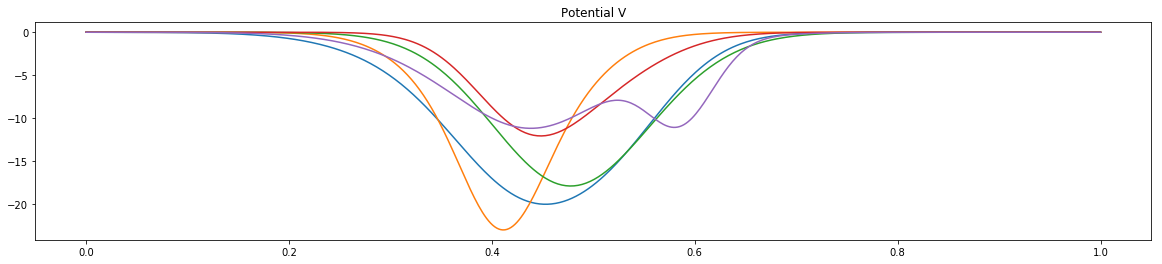

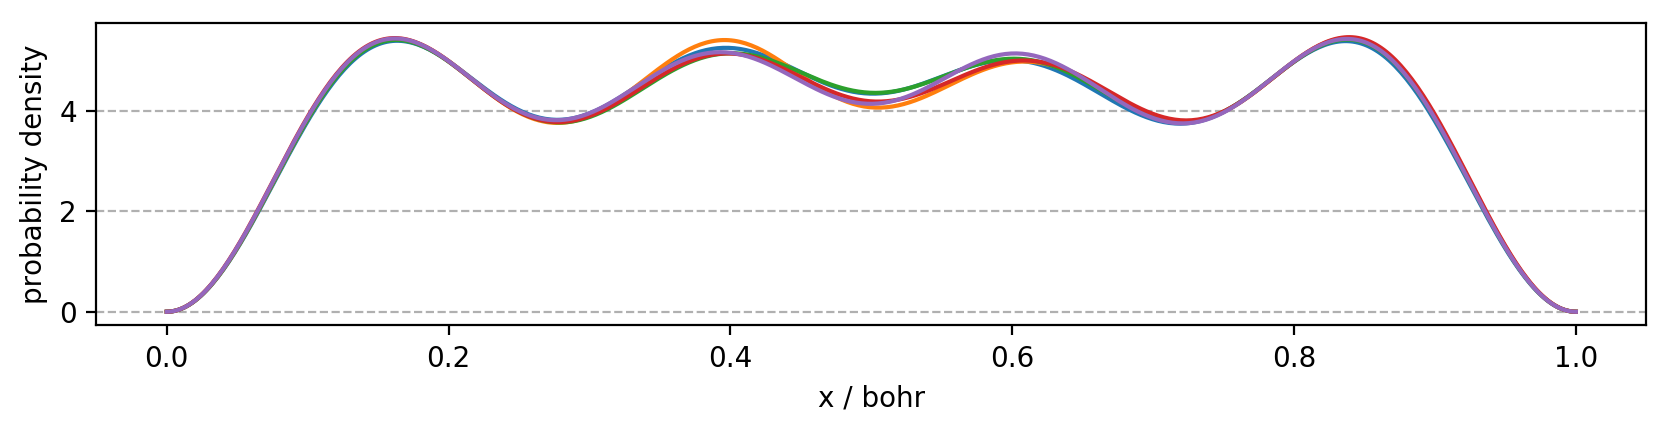

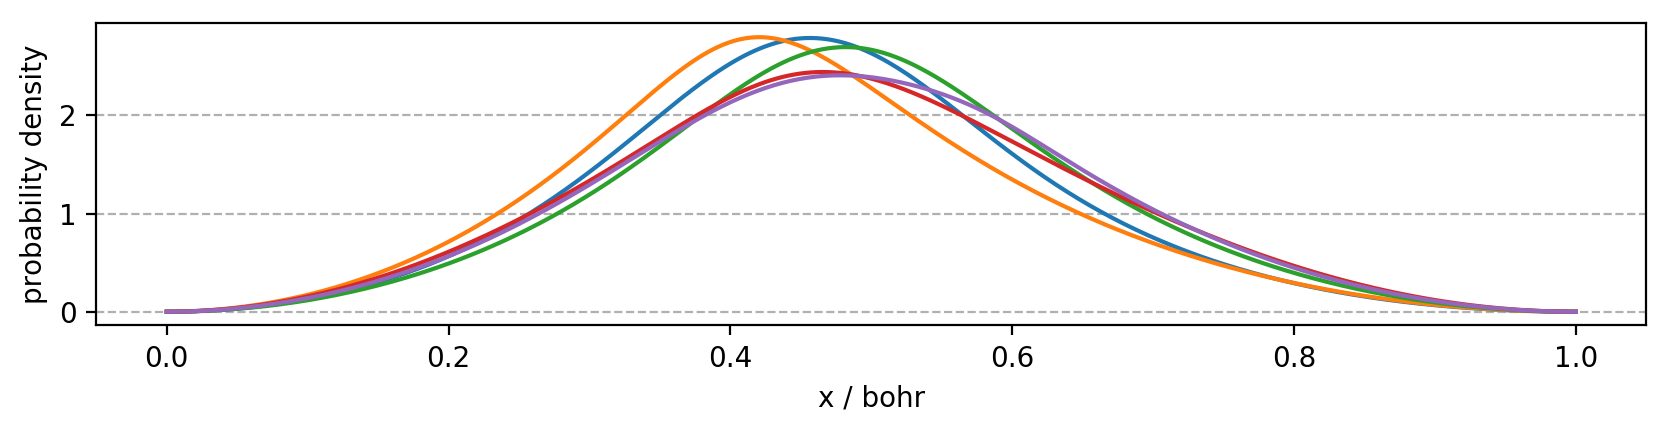

In [17]:
np_density = np.sum(np_solutions**2, axis=-1)

plt.figure(figsize=(20, 4))
plt.plot(np_x, np.transpose(np_potentials)[:, :preview])
plt.title('Potential V')
plt.show()

#plt.figure(figsize=(20, 4))
plt.figure(figsize=(10, 2), dpi=200)
for i, np_density_group in enumerate(np_density[:preview]):
    plt.plot(np_x, np_density_group, 'C' + str(i%10))
#plt.title('Total Density N=' + str(N))
plt.xlabel("x / bohr")
plt.ylabel("probability density")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

#plt.figure(figsize=(20, 4))
plt.figure(figsize=(10, 2), dpi=200)
for i, np_density_group in enumerate((np_solutions[:, :, 0]**2)[:preview]):
    plt.plot(np_x, np_density_group, 'C' + str(i%10))
#plt.title('Density N=1')
plt.xlabel("x / bohr")
plt.ylabel("probability density")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [0]:
np_laplace = laplace(np_solutions, h)
np_kinetic = -0.5*np_solutions*np_laplace
np_K = integrate_simpson(np_kinetic, h, axis=1)
np_potential = np.expand_dims(np_potentials, axis=2)*np_solutions**2
np_P = integrate_simpson(np_potential, h, axis=1)

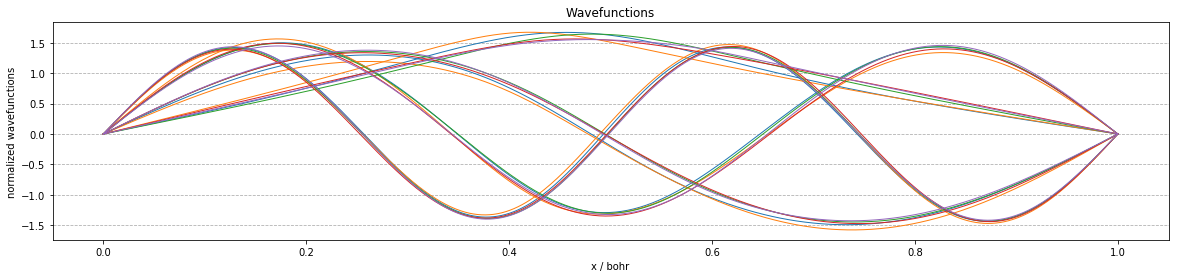

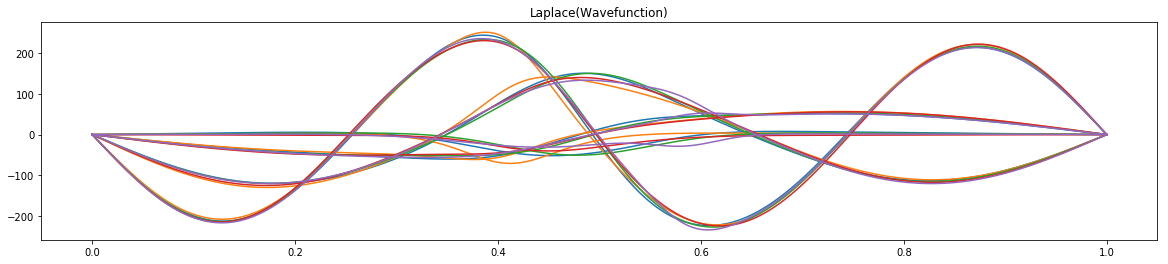

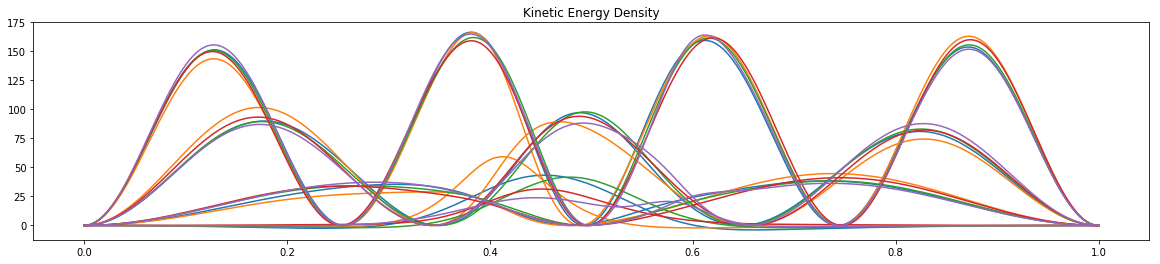

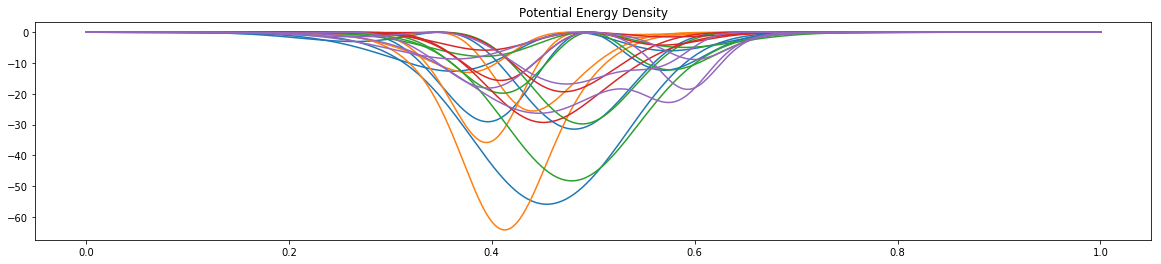

In [20]:
plt.figure(figsize=(20, 4))
#plt.figure(figsize=(10, 3), dpi=200)
for i, np_solutions_group in enumerate(np_solutions[:preview]):
    plt.plot(np_x, np_solutions_group, 'C' + str(i%10), linewidth=1)
plt.title('Wavefunctions')
plt.xlabel("x / bohr")
plt.ylabel("normalized wavefunctions")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_laplace_group in enumerate(np_laplace[:preview]):
    plt.plot(np_x, np_laplace_group, 'C' + str(i%10))
plt.title('Laplace(Wavefunction)')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_kinetic_group in enumerate(np_kinetic[:preview]):
    plt.plot(np_x, np_kinetic_group, 'C' + str(i%10))
plt.title('Kinetic Energy Density')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_potential_group in enumerate(np_potential[:preview]):
    plt.plot(np_x, np_potential_group, 'C' + str(i%10))
plt.title('Potential Energy Density')
plt.show()

In [21]:
total_energy = np.sum(np_E, axis=-1)
print('total energy:', total_energy[:5])

potential_energy = np.sum(np_P, axis=-1)
print('potential energy:', potential_energy[:5])

kinetic_energy = np.sum(np_K, axis=-1)
print('kinetic energy direct:', kinetic_energy[:5])

np_K_id = np_E - np_P
kinetic_energy_id = np.sum(np_K_id, axis=-1)
print('kinetic energy indirect:', kinetic_energy_id[:5])

assert(not np.any(np.isnan(np_density)))
assert(not np.any(np.isnan(np_kinetic)))
assert(not np.any(np.isnan(kinetic_energy)))
assert(not np.any(np.isnan(kinetic_energy_id)))

total energy: [127.01015 133.23163 131.93634 138.95145 133.73358]
potential energy: [-21.55390679 -15.19749151 -16.51185451  -9.25152808 -14.51148396]
kinetic energy direct: [148.55820496 148.42329697 148.44236708 148.19718406 148.23927343]
kinetic energy indirect: [148.56404911 148.42912923 148.44819246 148.20298367 148.24507433]
